<a href="https://colab.research.google.com/github/2002sahapriya/SYDE552-Final-Project/blob/master/SYDE552_Final_Project_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
!pip install opencv-python

In [ ]:
!pip install keras-vggface

In [ ]:
!pip install keras==2.12
!pip install git+https://github.com/rcmalli/keras-vggface.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-kzkkna7c
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-kzkkna7c
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=a367ca54fcce87af605f8ffbfe0e26fcac8ead0f

In [ ]:
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import os
import urllib.request
from zipfile import ZipFile
import tarfile
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import bz2
import shutil
import gdown
import gzip
from skimage import io
import pickle

In [ ]:
from keras_vggface.vggface import VGGFace
from keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Reshape, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input

# Download Dataset

In [ ]:
# Function to download and extract the dataset
def download_and_extract(dataset_url, download_path='datasets/normal_face.tgz', extract_path='datasets/normal_faces', remove_file = True):
    if not os.path.exists(extract_path):
        os.makedirs(os.path.dirname(download_path), exist_ok = True)
        print("Downloading dataset...")
        urllib.request.urlretrieve(dataset_url, download_path)
        print("Download complete.")

        # Extract the zip file
        print("Extracting dataset...")
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(path=os.path.dirname(extract_path))
        print("Extraction complete.")

        # Optionally, remove the zip file
        if remove_file:
            os.remove(download_path)
            print('Tar.gz file removed.')

        print("Dataset ready.")
    else:
        print("Dataset already downloaded and extracted.")

In [ ]:
# URL of the LFW dataset
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
# Set download to false if the download is not needed
download = True
if download:
    download_and_extract(dataset_url = lfw_url, remove_file = False)
    download = False

Download complete.
Extracting dataset...
Extraction complete.
Dataset ready.


In [ ]:
## RUN WITH CAUTION ##
def delete_non_empty_directory(dir_path, delete = False):
    if delete:
      # Check if the directory exists
      if os.path.exists(dir_path):
        # Remove the directory and all its contents
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_path}' has been removed along with all its contents.")
      else:
        print(f"The directory '{dir_path}' does not exist.")
    else:
      print('No directory deleted.')

# Usage
directory_to_delete = "modified_datasets"
delete_non_empty_directory(directory_to_delete, True)

Directory 'modified_datasets' has been removed along with all its contents.


# Blurring features

In [ ]:
def download_dlib_model(url, bz2_filename, dat_filename, remove_file = False):
    # Check if the decompressed .dat file already exists
    if not os.path.isfile(dat_filename):
        # Check if the compressed .bz2 file already exists
        if not os.path.isfile(bz2_filename):
            print(f"Downloading {bz2_filename}...")
            urllib.request.urlretrieve(url, bz2_filename)
            print(f"Downloaded {bz2_filename}.")

        # Decompress the .bz2 file to get the .dat file
        print(f"Decompressing {bz2_filename} to get {dat_filename}...")
        with bz2.BZ2File(bz2_filename, 'rb') as f_in:
            with open(dat_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {dat_filename}.")

        # Optionally, remove the .bz2 file after decompression
        if remove_file:
          os.remove(bz2_filename)
          print(f"Removed compressed file {bz2_filename}.")
    else:
        print(f"{dat_filename} already exists. No download needed.")

# URL to the dlib pre-trained facial landmark predictor
dlib_model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the compressed model
compressed_file_name = "shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the decompressed model
model_file_name = "shape_predictor_68_face_landmarks.dat"

# Call the function to download and decompress the model
download_dlib_model(dlib_model_url, compressed_file_name, model_file_name)

Downloaded shape_predictor_68_face_landmarks.dat.bz2.
Decompressing shape_predictor_68_face_landmarks.dat.bz2 to get shape_predictor_68_face_landmarks.dat...
Decompressed to shape_predictor_68_face_landmarks.dat.


In [ ]:
# Initialize dlib face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
def blur_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a blurring effect to specific features on the face by fitting an ellipse around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to blur.
    feature_type (str): The type of feature to blur ('eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature blurred.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull (the smallest convex polygon containing all points) for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points, which provides a better fit than an ellipse
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Depending on the feature, adjust the box dimensions
    if feature_type in ['eyes', 'mouth']:
        # For the eyes and mouth, expand the box horizontally
        center, size, angle = rect
        size = (size[0] * 1.4, size[1] * 1.2)  # Increase the size a bit for better coverage
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask
    cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)

    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Combine the original and blurred images using the mask
    combined_image = np.where(mask[..., None].astype(bool), blurred_image, image)

    return combined_image

In [ ]:
def mask_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a black mask to specific features on the face by fitting a rotated rectangle around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to mask.
    feature_type (str): The type of feature to mask ('eyebrows', 'eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature masked with a black box.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Adjust the box dimensions based on the feature
    if feature_type in ['eyes', 'mouth', 'eyebrows']:
        # For the eyes, mouth, and eyebrows, expand the box slightly for better coverage
        center, size, angle = rect
        if feature_type == 'eyebrows':
            size = (size[0] * 1.2, size[1] * 1.5)  # Eyebrows are thinner but wider
        else:
            size = (size[0] * 1.4, size[1] * 1.2)  # Eyes and mouth
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box more vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask with white color
    cv2.drawContours(mask, [box], 0, (255), -1)

    # Mask the feature by setting the pixels inside the mask to black in the original image
    image[mask == 255] = [0, 0, 0]  # Set to black

    return image


In [ ]:
from skimage import io
detector = dlib.get_frontal_face_detector()
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Path to the facial landmark predictor file
predictor = dlib.shape_predictor(predictor_path)  # Load the facial landmark predictor

# Function to save an image
def save_image(image, path, filename):
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(os.path.join(path, filename), image)

def check_feature_visibility(landmarks, indices):
    """ Check if all indices in a feature have detectable landmarks """
    return all(landmarks.part(i) for i in indices)

def create_and_save_masked_datasets(base_path, save_path, target_size=(224, 224)):
    labels = {'normal': [], 'masked_eyebrows': [], 'masked_eyes': [], 'masked_nose': [], 'masked_mouth': []}

    for individual in os.listdir(os.path.join(base_path, 'lfw')):
        individual_path = os.path.join(base_path, 'lfw', individual)

        for image_file in os.listdir(individual_path):
            if image_file.lower().endswith('.jpg'):
                image_path = os.path.join(individual_path, image_file)
                image = io.imread(image_path)
                image = cv2.resize(image, target_size)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                faces = detector(gray, 1)
                face_detected = False
                if len(faces) > 0:
                    face = faces[0]
                    landmarks = predictor(gray, face)
                    # Indices for eyebrows, eyes, nose, and mouth features
                    eyebrows_indices = list(range(17, 27))  # Add eyebrows
                    eyes_indices = list(range(36, 42)) + list(range(42, 48))
                    nose_indices = list(range(27, 36))
                    mouth_indices = list(range(48, 68))

                    # Check visibility of each feature
                    has_eyebrows = check_feature_visibility(landmarks, eyebrows_indices)
                    has_eyes = check_feature_visibility(landmarks, eyes_indices)
                    has_nose = check_feature_visibility(landmarks, nose_indices)
                    has_mouth = check_feature_visibility(landmarks, mouth_indices)

                    if has_eyebrows and has_eyes and has_nose and has_mouth:
                        face_detected = True
                        masked_eyebrows = mask_feature(image.copy(), landmarks, eyebrows_indices, 'eyebrows')
                        masked_eyes = mask_feature(image.copy(), landmarks, eyes_indices, 'eyes')
                        masked_nose = mask_feature(image.copy(), landmarks, nose_indices, 'nose')
                        masked_mouth = mask_feature(image.copy(), landmarks, mouth_indices, 'mouth')
                    else:
                        masked_eyebrows, masked_eyes, masked_nose, masked_mouth = image.copy(), image.copy(), image.copy(), image.copy()

                save_image(image, os.path.join(save_path, 'normal'), image_file)
                save_image(masked_eyebrows, os.path.join(save_path, 'masked_eyebrows'), image_file)
                save_image(masked_eyes, os.path.join(save_path, 'masked_eyes'), image_file)
                save_image(masked_nose, os.path.join(save_path, 'masked_nose'), image_file)
                save_image(masked_mouth, os.path.join(save_path, 'masked_mouth'), image_file)

                # Update labels based on the feature visibility
                face_label = 1 if face_detected else 0
                labels['normal'].append(face_label)
                labels['masked_eyebrows'].append(face_label)
                labels['masked_eyes'].append(face_label)
                labels['masked_nose'].append(face_label)
                labels['masked_mouth'].append(face_label)

    for key in labels:
        labels_path = os.path.join(save_path, key)
        if not os.path.exists(labels_path):
            os.makedirs(labels_path)
        np.save(os.path.join(labels_path, 'labels.npy'), np.array(labels[key]))

In [ ]:
# Example usage of the function
base_path = 'datasets'  # Base path to the LFW dataset
save_path = 'modified_datasets'  # Path where you want to save the new datasets
create_and_save_masked_datasets(base_path, save_path)

# Loading Images for Training

In [ ]:
def load_images_from_directory(directory, label_file, target_size=(224, 224)):
    """
    Loads images from a directory and their corresponding labels from a .npy file.
    Assumes that images are named in such a way that sorting them alphabetically
    matches the order of labels in the label file.
    """
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    image_files.sort()  # Sort files to ensure correct order with labels

    images = []
    for filename in image_files:
        filepath = os.path.join(directory, filename)
        image = cv2.imread(filepath)
        if image is not None:
            image = cv2.resize(image, target_size)
            images.append(image)

    # Load labels from the .npy file
    labels = np.load(label_file)

    # Convert list of images to a numpy array
    images = np.array(images)

    return images, labels

In [ ]:
from sklearn.model_selection import train_test_split
def save_datasets_memory_map(X_train, X_val, X_test, y_train, y_val, y_test, save_path):
    os.makedirs(save_path, exist_ok=True)
    np.save(os.path.join(save_path, 'X_train.npy'), X_train)
    np.save(os.path.join(save_path, 'X_val.npy'), X_val)
    np.save(os.path.join(save_path, 'X_test.npy'), X_test)
    np.save(os.path.join(save_path, 'y_train.npy'), y_train)
    np.save(os.path.join(save_path, 'y_val.npy'), y_val)
    np.save(os.path.join(save_path, 'y_test.npy'), y_test)

def split_data(images, labels, save_path, test_size=0.2, val_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
    # save datasets as memory maps
    save_datasets_memory_map(X_train, X_val, X_test, y_train, y_val, y_test, save_path)
    return None

In [ ]:
def load_data_from_files(save_path):
    X_train = np.load(os.path.join(save_path, 'X_train.npy'), mmap_mode='r')
    X_test = np.load(os.path.join(save_path, 'X_test.npy'), mmap_mode='r')
    X_val = np.load(os.path.join(save_path, 'X_val.npy'), mmap_mode='r')
    y_train = np.load(os.path.join(save_path, 'y_train.npy'), mmap_mode='r')
    y_test = np.load(os.path.join(save_path, 'y_test.npy'), mmap_mode='r')
    y_val = np.load(os.path.join(save_path, 'y_val.npy'), mmap_mode='r')
    return X_train, X_test, X_val, y_train, y_test, y_val

# Metrics

1. **Precision** measures the accuracy of positive predictions (i.e., the proportion of predicted positives that are actually true positives).
2. **Recall** measures the ability of the classifier to find all the positive samples (i.e., how well the model can detect actual positives from the dataset).
3. **F1 Score** is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.
4. **Confusion Matrix** is a table used to describe the performance of a classification model on a set of data for which the true values are known. It provides insights not just into the errors being made by a classifier but more importantly the types of errors.

In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def calculate_precision_recall_f1(y_true, y_pred):
    # True positives, false positives, false negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
def plot_confusion_matrix(cm, classes=['Not Detected', 'Detected'],
                          title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Example usage
# Sample labels (0: not detected, 1: detected)
y_true = np.array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1])
y_pred = np.array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)


# Load the data for all teh datasets

In [ ]:
# Load images and labels - normal dataset
directory = 'modified_datasets/normal'
label_file = 'modified_datasets/normal/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/normal'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data_from_files(save_path)

In [ ]:
# Load images and labels - eyebrows
directory = 'modified_datasets/masked_eyebrows'
label_file = 'modified_datasets/masked_eyebrows/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_eyebrows'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_brows, X_test_brows, X_val_brows, y_train_brows, y_test_brows, y_val_brows = load_data_from_files(save_path)

In [ ]:
# Load images and labels - eyes
directory = 'modified_datasets/masked_eyes'
label_file = 'modified_datasets/masked_eyes/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_eyes'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_eyes, X_test_eyes, X_val_eyes, y_train_eyes, y_test_eyes, y_val_eyes = load_data_from_files(save_path)

In [ ]:
# Load images and labels - nose
directory = 'modified_datasets/masked_nose'
label_file = 'modified_datasets/masked_nose/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_nose'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_nose, X_test_nose, X_val_nose, y_train_nose, y_test_nose, y_val_nose = load_data_from_files(save_path)

In [ ]:
# Load images and labels - mouth
directory = 'modified_datasets/masked_mouth'
label_file = 'modified_datasets/masked_mouth/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_mouth'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_mouth, X_test_mouth, X_val_mouth, y_train_mouth, y_test_mouth, y_val_noise = load_data_from_files(save_path)

## Let's do this from scratch - one final time!!

# Original Model

In [ ]:
from keras.backend import clear_session
# Original model
def build_model():
  # Load VGGFace model
  base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

  # Add new classifier layers
  flat1 = Flatten()(base_model.output)
  output = Dense(1, activation='sigmoid')(flat1)
  final_model = Model(inputs=base_model.inputs, outputs=output)

  # Compile the model
  final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Display model summary
  # final_model.summary()

  return final_model


# Reset the Keras session
clear_session()
# build the model
face_model = build_model()

In [ ]:
# Training the model on good data
history = face_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Call to plot_history function with the history object
plot_history(history)

# Activation Maps

In [ ]:
# Activation Heat maps
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import cv2

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Model with both the last CNN layer and classifier layers output
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output] + [model.get_layer(name).output for name in classifier_layer_names])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass
        last_conv_layer_output, preds = grad_model(img_array)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Gradient of top predicted class with respect to the output feature map of last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This vector contains importance weights of each channel in feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by their importance to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to plot the original image and heatmaps
def plot_heatmaps(img_path, model, layers, classifier_layer_names):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = preprocess_input(img)  # Add your preprocessing logic here
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Plot original image
    plt.figure(figsize=(10, 3))
    plt.subplot(1, len(layers) + 1, 1)
    plt.imshow(img)
    plt.axis('off')

    # Generate and plot heatmaps for each layer
    for i, layer in enumerate(layers, start=2):
        heatmap = make_gradcam_heatmap(img_array, model, layer, classifier_layer_names)
        plt.subplot(1, len(layers) + 1, i)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
        plt.title(layer)
        plt.axis('off')

    plt.tight_layout()
    plt.colorbar()
    plt.show()

# List of layers to check
later_layers = ['conv5_1', 'conv5_2', 'conv5_3']
early_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2']
middle_layers = ['conv4_1', 'conv4_2', 'conv4_3']
classifier_layer_names = ["dense_1"]  # Names of classifier layers in your model

# Define paths to your datasets
image_paths = {
    'normal': 'modified_datasets/normal/AJ_Cook_0001.jpg',
    'eyebrows': 'modified_datasets/masked_eyebrows/AJ_Cook_0001.jpg',
    'eyes': 'modified_datasets/masked_eyes/AJ_Cook_0001.jpg',
    'nose': 'modified_datasets/masked_nose/AJ_Cook_0001.jpg',
    'mouth': 'modified_datasets/masked_mouth/AJ_Cook_0001.jpg'
}

Analyzing feature: normal


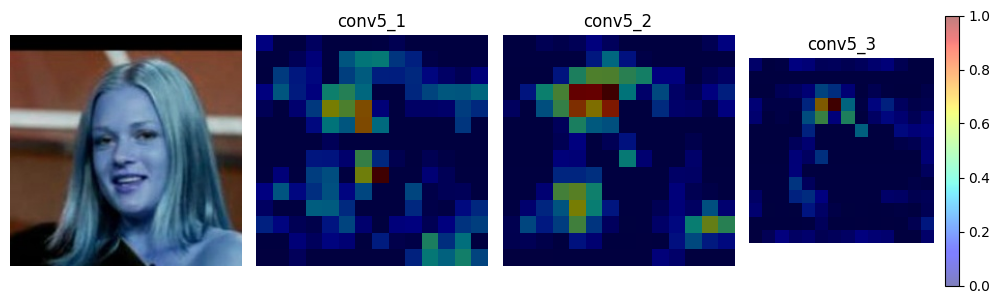

Analyzing feature: eyebrows


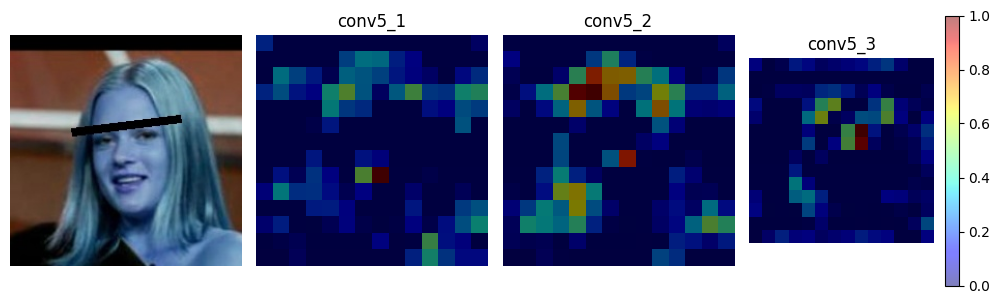

Analyzing feature: eyes


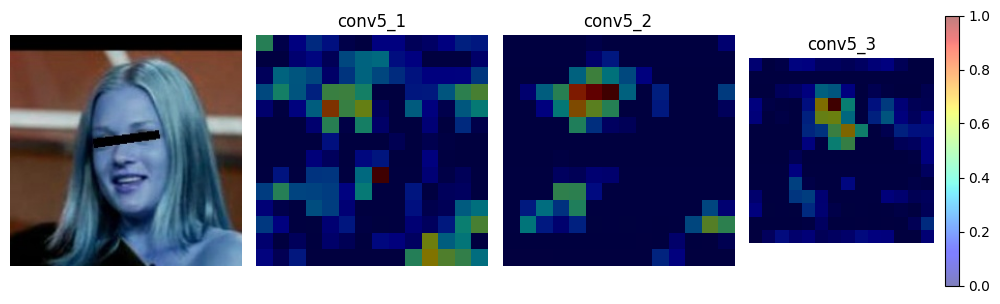

Analyzing feature: nose


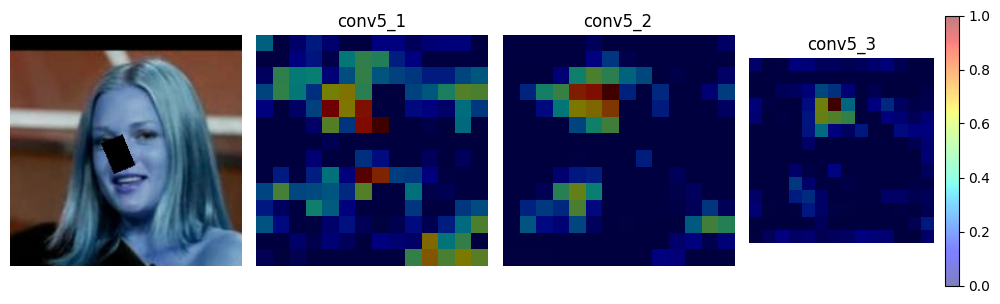

Analyzing feature: mouth


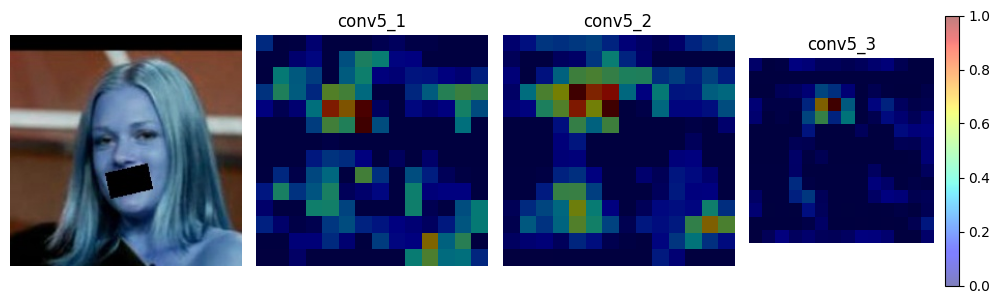

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, later_layers, classifier_layer_names)

Analyzing feature: normal


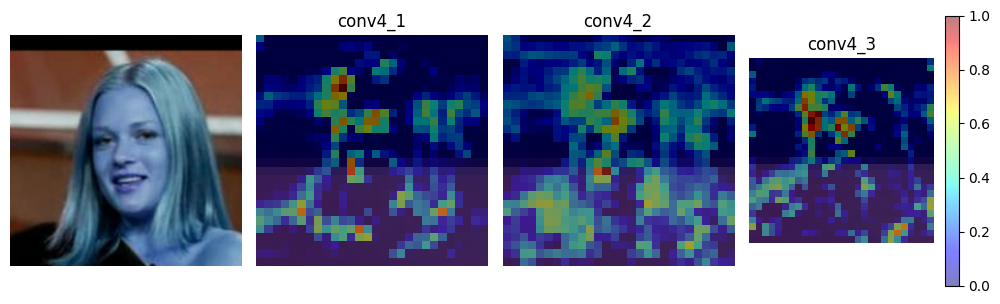

Analyzing feature: eyebrows


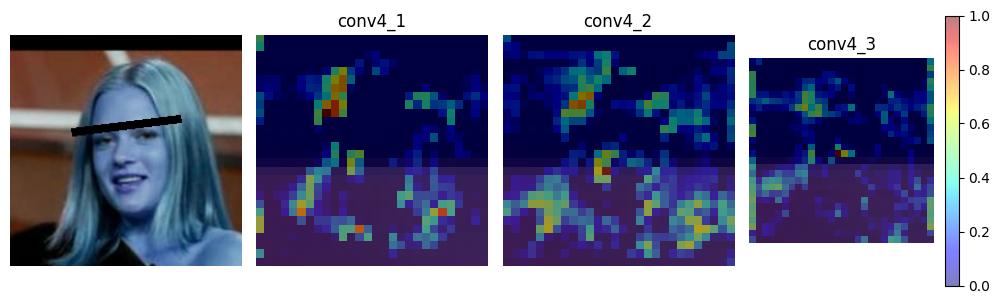

Analyzing feature: eyes


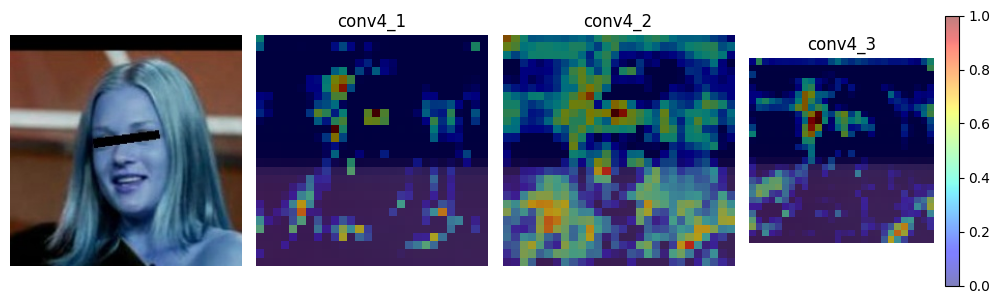

Analyzing feature: nose


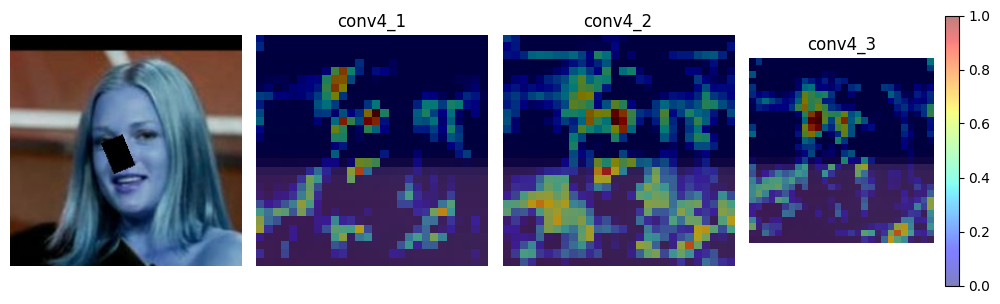

Analyzing feature: mouth


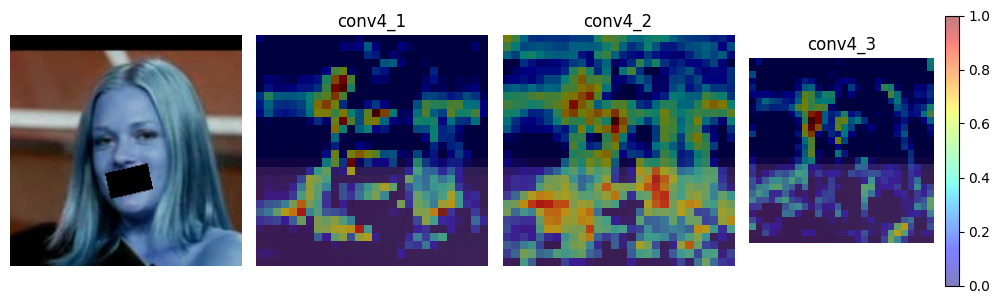

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, middle_layers, classifier_layer_names)

Analyzing feature: normal


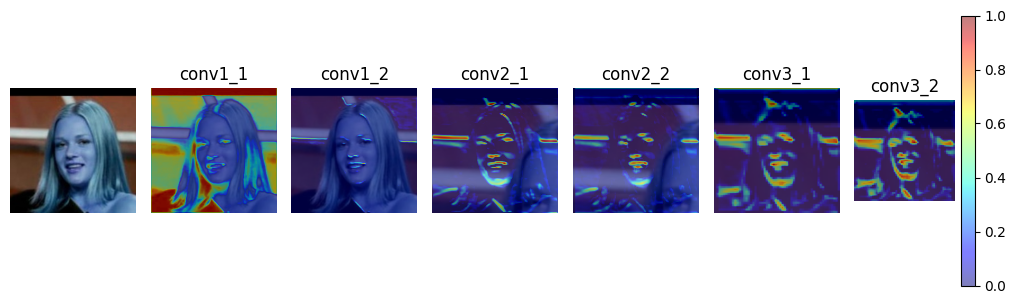

Analyzing feature: eyebrows


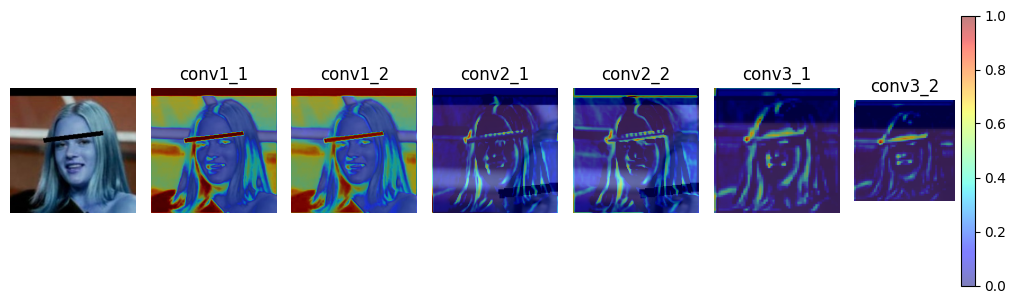

Analyzing feature: eyes


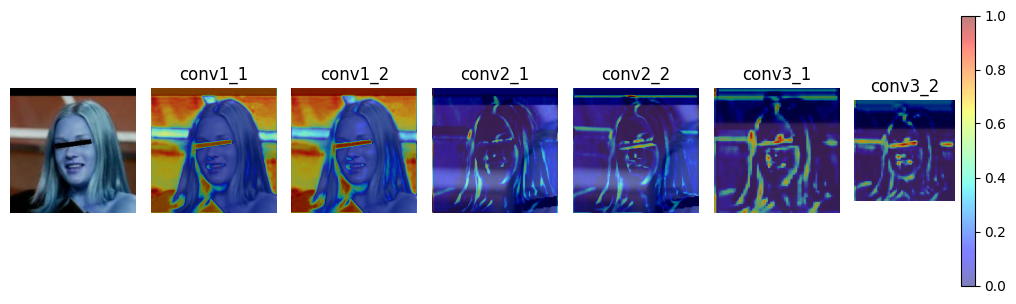

Analyzing feature: nose


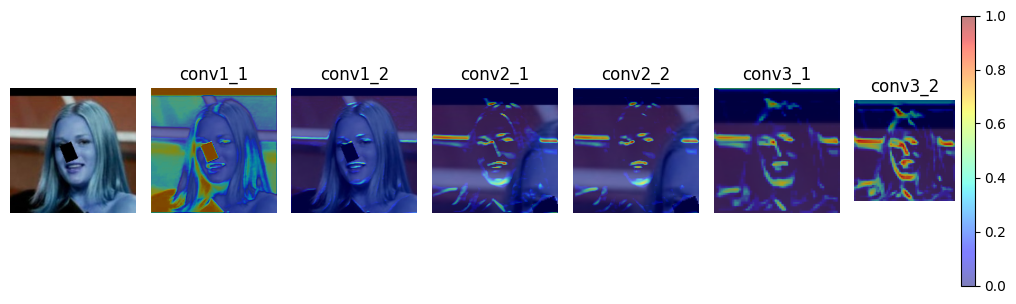

Analyzing feature: mouth


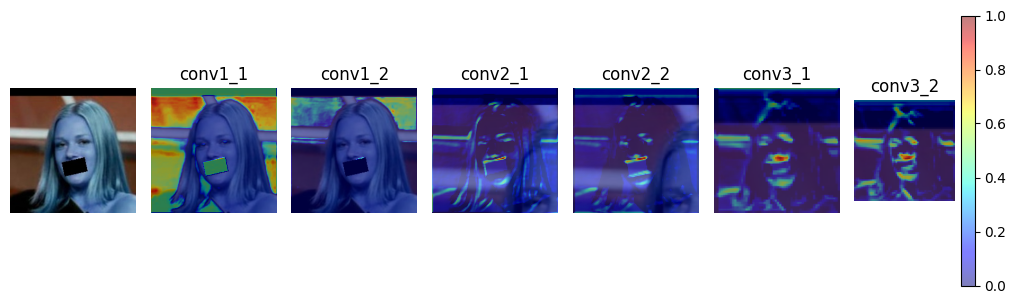

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, early_layers, classifier_layer_names)

In [ ]:
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Original model accuracy with normal data", accuracy)

83/83 [==============================] - 8s 97ms/step
Original model accuracy with normal data 0.8689081979599547


In [ ]:
clear_session()
face_model = build_model()
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Original model accuracy with masked brows data", accuracy)

83/83 [==============================] - 8s 98ms/step
Original model accuracy with masked brows data 0.7990177559501322


In [ ]:
clear_session()
face_model = build_model()
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Original model accuracy with masked eyes data", accuracy)

83/83 [==============================] - 8s 96ms/step
Original model accuracy with masked eyes data 0.9267094824329429


In [ ]:
clear_session()
face_model = build_model()
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Original model accuracy with masked nose data", accuracy)

83/83 [==============================] - 8s 98ms/step
Original model accuracy with masked nose data 0.5904797884397431


In [ ]:
clear_session()
face_model = build_model()
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Original model accuracy with masked mouth data", accuracy)

83/83 [==============================] - 8s 97ms/step
Original model accuracy with masked mouth data 0.8775972799395542


# Neurological Deficits

In [ ]:
# Neurological deficit  - ablate conv4_3 to conv5_3

from keras.models import Model
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Flatten, Dense, Lambda
import tensorflow as tf

def build_model_with_ablation(ablation_layers):
    # Load VGGFace model
    base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Function to zero-out activations
    def ablate_features(x, layers_to_ablate):
        for layer_name in layers_to_ablate:
            if base_model.get_layer(layer_name) == x.name:
                return tf.zeros_like(x)
        return x

    # Add ablation layers after convolutional layers
    x = base_model.input
    for layer in base_model.layers:
        layer_output = layer(x)
        # Apply ablation if the layer is in the ablation list
        x = Lambda(lambda x: ablate_features(x, ablation_layers), name=f'ablated_{layer.name}')(layer_output)

    # Add new classifier layers
    flat1 = Flatten()(x)
    output = Dense(1, activation='sigmoid')(flat1)

    # Define the new model
    model_with_ablation = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model_with_ablation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_with_ablation

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
layers_to_ablate = ['conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# Build the model with feature ablation
face_model_with_ablation = build_model_with_ablation(layers_to_ablate)

# Display the summary to confirm the ablation layers are included
face_model_with_ablation.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 ablated_input_2 (Lambda)       (None, 224, 224, 3)  0           ['input_2[1][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_2[0][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 95ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.6018133736305251


In [ ]:
# Test the ablated model - masked eyebrows
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.5375897242160937


In [ ]:
# Test the ablated model - masked eyes
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.5470343785417454


In [ ]:
# Test the ablated model - masked nose
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.40763128069512655


In [ ]:
# Test the ablated model - masked mouth
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.5440120891575368


In [ ]:
# Specify the layers to be ablated based on Grad-CAM results
layers_to_ablate = [ 'conv3_2', 'conv4_2', 'conv5_3' ]

# Build the model with feature ablation
face_model_with_ablation_2 = build_model_with_ablation(layers_to_ablate)

# Display the summary to confirm the ablation layers are included
face_model_with_ablation_2.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           multiple             0           ['input_4[0][0]']                
                                                                                                  
 ablated_input_4 (Lambda)       (None, 224, 224, 3)  0           ['input_4[1][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_4[0][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]: 0.10691348696637704


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]: 0.13071401586701928


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 96ms/step
Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]: 0.10691348696637704


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]: 0.09104646769928221


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with abalation accuracy [Ablated layers: conv3_2, conv4_2, conv5_3]: 0.03702304495655459


In [ ]:
# Specify the layers to be ablated based on Grad-CAM results
layers_to_ablate = ['conv3_1', 'conv3_2', 'conv3_3']

# Build the model with feature ablation
face_model_with_ablation_3 = build_model_with_ablation(layers_to_ablate)

# Display the summary to confirm the ablation layers are included
face_model_with_ablation_3.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           multiple             0           ['input_3[0][0]']                
                                                                                                  
 ablated_input_3 (Lambda)       (None, 224, 224, 3)  0           ['input_3[1][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_3[0][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']         

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_3.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]: 0.6970154892330941


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_3.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]: 0.8084624102757839


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_3.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]: 0.7162825840574235


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_3.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]: 0.634680770683793


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation_3.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]:", accuracy)

83/83 [==============================] - 8s 100ms/step
Face model with abalation accuracy [Ablated layers: conv3_1, conv3_2, conv3_3]: 0.6985266339251983


# Adding noise to specific layers

In [ ]:
from keras.models import clone_model
from keras.layers import GaussianNoise

def add_noise_to_specific_layers(base_model, noise_layers, noise_level=0.1):
    """
    Adds Gaussian noise to the output of specific layers without modifying the base model.

    :param base_model: The base Keras model.
    :param noise_layers: A list of layer names to which noise should be added.
    :param noise_level: The standard deviation of the noise distribution.
    :return: A new model with noise injection.
    """
    # Clone the base model
    model_clone = clone_model(base_model)
    model_clone.set_weights(base_model.get_weights())

    # Rebuild model architecture and add noise to the specified layers
    x = model_clone.input
    for layer in model_clone.layers:
        if layer.name in noise_layers:
            # Add Gaussian noise after the specified layer
            x = GaussianNoise(noise_level)(layer(x))
        else:
            x = layer(x)

    # Create the new model with noise injection
    model_with_noise = Model(inputs=model_clone.input, outputs=x)
    model_with_noise.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_with_noise

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
noisy_layers = ['conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# Build the model with feature ablation
noise_face_model = add_noise_to_specific_layers(face_model, noisy_layers, noise_level=0.8)


# Display the summary to confirm the ablation layers are included
noise_face_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.8843974310540235


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 100ms/step
Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.9319984888553079


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.8843974310540235


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 95ms/step
Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.9093313184737438


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 95ms/step
Face model with Noise Injection [Noisy layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.8027956176803929


In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
noisy_layers = ['conv3_2', 'conv4_2', 'conv5_3']

# Build the model with feature ablation
noise_face_model_2 = add_noise_to_specific_layers(face_model, noisy_layers, noise_level=0.8)


# Display the summary to confirm the ablation layers are included
noise_face_model_2.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 95ms/step
Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]: 0.3324518322629392


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]: 0.4389875330562901


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]: 0.3324518322629392


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]: 0.5848129958443521


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = noise_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Noise Injection [Noisy layers: conv3_2, conv4_2, conv5_3]: 0.4174537211938043


# Dropout Layer

In [ ]:
from keras.models import clone_model
from keras.layers import Dropout

def add_selective_dropout(base_model, dropout_layers, dropout_rate=0.5):
    """
    Adds dropout to specific layers without modifying the base model.

    :param base_model: The base Keras model.
    :param dropout_layers: A list of layer names where dropout should be added.
    :param dropout_rate: The dropout rate.
    :return: A new model with selective dropout.
    """
    # Clone the base model
    model_clone = clone_model(base_model)
    model_clone.set_weights(base_model.get_weights())

    # Rebuild model architecture and add dropout to the specified layers
    x = model_clone.input
    for layer in model_clone.layers:
        if layer.name in dropout_layers:
            # Add dropout after the specified layer
            x = Dropout(dropout_rate)(layer(x))
        else:
            x = layer(x)

    # Create the new model with selective dropout
    model_with_dropout = Model(inputs=model_clone.input, outputs=x)
    # Compile the new model as needed
    model_with_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_with_dropout

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
dropout_layers = ['conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# Build the model with feature ablation
dropout_face_model = add_selective_dropout(face_model, dropout_layers, dropout_rate=0.8)


# Display the summary to confirm the ablation layers are included
dropout_face_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.46089913109180203


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.393275406120136


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 100ms/step
Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.46089913109180203


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.4117869285984133


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Selective Dropout [Dropout layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.426898375519456


In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
dropout_layers = ['conv3_2', 'conv4_2', 'conv5_3']

# Build the model with feature ablation
dropout_face_model_2 = add_selective_dropout(face_model, dropout_layers, dropout_rate=0.8)


# Display the summary to confirm the ablation layers are included
dropout_face_model_2.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]: 0.01511144692104269


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]: 0.010200226671703816


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]: 0.01511144692104269


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]: 0.01511144692104269


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout_face_model_2.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 96ms/step
Face model with Selective Dropout [Dropout layers: conv3_2, conv4_2, conv5_3]: 0.062334718549301095


# Combine dropout, ablation, and noise

In [ ]:
# Specify the layers to be ablated based on Grad-CAM results
layers = ['conv3_2', 'conv4_3', 'conv5_3']

# Add feature ablation
ablation = build_model_with_ablation(layers)
# Add noise
noise = add_noise_to_specific_layers(ablation, noisy_layers, noise_level=0.8)

# Add dropout
dropout = add_selective_dropout(noise , dropout_layers, dropout_rate=0.8)
dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

dropout.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.floa

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 ablated_input_2 (Lambda)       (None, 224, 224, 3)  0           ['input_2[2][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_2[1][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 98ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.019644880997355497


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 99ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.028333962976955042


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.019644880997355497


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 97ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.013222516055912353


In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 95ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.0415564790328674


# Creating Datasets

In [ ]:
import cv2
import dlib
import numpy as np

# Load dlib's pre-trained face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Make sure to download this

In [ ]:
# Initialize dlib's face detector (HOG-based) and load the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')  # Path to the model

def get_feature_mask(image, feature_indices, scale=1.0):
    """
    Creates a mask for the specified feature by enlarging the bounding box around the detected feature points.
    Args:
    image (numpy array): The original image.
    feature_indices (list): A list of landmark indices that define the feature.
    scale (float): How much to scale the bounding box of the feature for the mask.

    Returns:
    numpy array: The mask with the specified feature highlighted.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)

    if faces:
        face = faces[0]
        landmarks = predictor(gray, face)
        feature_coords = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices])
        feature_bbox = cv2.boundingRect(feature_coords)
        x, y, w, h = feature_bbox
        x_center, y_center = x + w // 2, y + h // 2
        new_width, new_height = int(w * scale), int(h * scale)
        x, y = int(x_center - new_width // 2), int(y_center - new_height // 2)

        mask = np.zeros_like(image)
        cv2.rectangle(mask, (x, y), (x + new_width, y + new_height), (255, 255, 255), -1)
        return mask
    else:
        # If no faces are detected, return an empty mask
        return np.zeros_like(image)

def blur_except_feature(image, feature_indices, scale=1.0):
    """
    Blurs the entire image except for the specified feature.
    """
    mask = get_feature_mask(image, feature_indices, scale)
    blurred_image = cv2.GaussianBlur(image, (21, 21), 0)
    final_image = np.where(mask == np.array([255, 255, 255]), image, blurred_image)
    return final_image

In [ ]:
def process_images(images, feature_indices, scale=1.0):
    # Loop over each image and process it
    processed_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed_img = blur_except_feature(img, feature_indices, scale)
        processed_images.append(processed_img)
    return processed_images

In [ ]:
# Eyebrows indices according to dlib's 68 facial landmarks
eyebrows_indices = list(range(17, 27))  # Eyebrows
# Eyes indices according to dlib's 68 facial landmarks
eyes_indices = list(range(36, 48))  # Eyes, including both the left and right eyes
# Nose indices according to dlib's 68 facial landmarks
nose_indices = list(range(27, 36))  # Nose
# Mouth indices according to dlib's 68 facial landmarks
mouth_indices = list(range(48, 68))  # Mouth

In [ ]:
# Process images to create feature-specific datasets
eyebrows_images = process_images(X_val[:1], eyebrows_indices, scale=1.5)
eyes_images = process_images(X_val[:1], eyes_indices, scale=1.5)
nose_images = process_images(X_val[:1], nose_indices, scale=1.5)
mouth_images = process_images(X_val[:1], mouth_indices, scale=1.5)

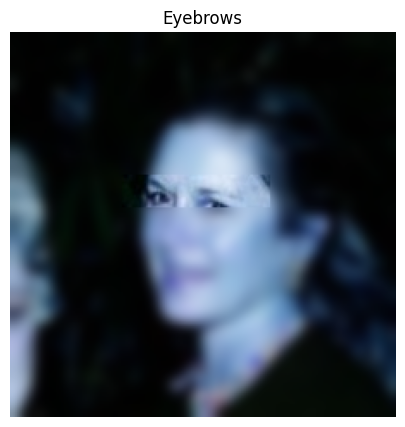

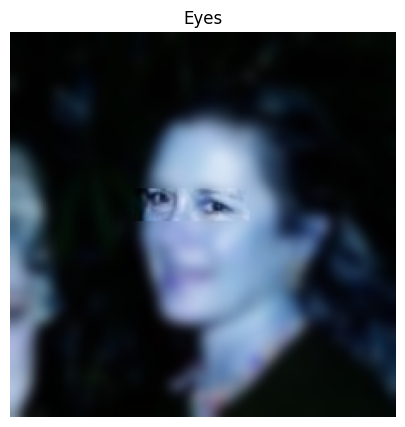

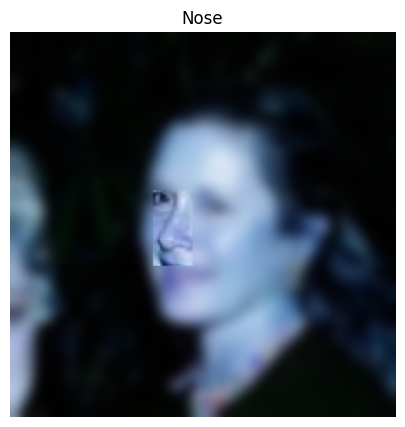

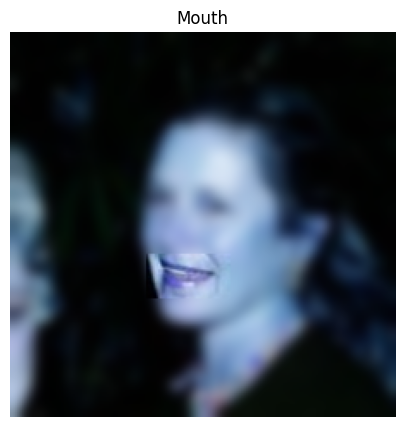

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, title):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.show()

# Show processed images
show_images(eyebrows_images, "Eyebrows")
show_images(eyes_images, "Eyes")
show_images(nose_images, "Nose")
show_images(mouth_images, "Mouth")

# Functions that help us find neurons that responsible for detecting features

In [ ]:
feature_eyes = np.array([img_to_array(image) for image in eyes_images])  # 'eyes_images' should be your dataset of images
feature_eyebrows = np.array([img_to_array(image) for image in eyebrows_images])  # 'eyebrows_images' should be your dataset of images
feature_nose = np.array([img_to_array(image) for image in nose_images])  # 'nose_images' should be your dataset of images
feature_mouth = np.array([img_to_array(image) for image in mouth_images])  # 'mouth_images' should be your dataset of images

In [ ]:
def print_neurons_indices(neurons_indices_dict):
    for layer_name, neurons in neurons_indices_dict.items():
        print(f"Neurons in layer {layer_name} responsible for detecting the feature:", neurons)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def get_activations(model, layer_name, input_images):
    # Ensure input_images is 4D (batch_size, height, width, channels)
    if input_images.ndim == 3:
        input_images = np.expand_dims(input_images, axis=0)

    # Create a model that returns the outputs of the specified layer
    layer_output = model.get_layer(layer_name).output
    activation_model = Model(inputs=model.input, outputs=layer_output)

    # Predict and collect activations for the batch of images
    activations = activation_model.predict(input_images)
    return activations

def find_responsible_neurons(activations, threshold=0.75):
    # Assuming activations shape is (batch, height, width, channels)
    # Calculate the mean activation across all spatial dimensions and the batch
    mean_activation = np.mean(activations, axis=(0, 1, 2))

    # Threshold based on a percentage of the maximum activation to find highly activated neurons
    threshold_value = np.max(mean_activation) * threshold
    active_neurons = np.where(mean_activation >= threshold_value)[0]

    return active_neurons.tolist()

# Example usage:
# Model and layer to analyze
layer_name = 'conv1_1'

# Getting activations
activations = get_activations(face_model, layer_name, feature_eyes)

# Finding responsible neurons
responsible_neurons = find_responsible_neurons(activations)

print("Responsible Neurons:", responsible_neurons)


1/1 [==============================] - 0s 43ms/step
Responsible Neurons: [46, 47, 55]


# Custom Layer for Neuron Manipulation

In [ ]:
from keras.layers import Layer
import keras.backend as K
import numpy as np

class NeuronManipulationLayer(Layer):
    def __init__(self, neuron_indices, manipulation_values, **kwargs):
        """
        A custom Keras layer to manipulate specific neurons by adding a constant value.

        :param neuron_indices: Indices of the neurons to manipulate.
        :param manipulation_values: Values to add to the neuron outputs. Can be positive (to activate)
                                    or negative (to inhibit).
        """
        super().__init__(**kwargs)
        self.neuron_indices = neuron_indices
        self.manipulation_values = manipulation_values
        self.manipulation_vector = None

    def build(self, input_shape):
        # The number of filters in the previous layer determines the size of the manipulation vector
        num_filters = input_shape[-1]  # Assuming the last dimension in the input shape is the channel/filter dimension
        manipulation_vector = np.zeros(num_filters)  # Initialize a vector of zeros with the same size as the number of filters
        # Set the manipulation values for specified neurons
        for index, value in zip(self.neuron_indices, self.manipulation_values):
            if index < num_filters:
                manipulation_vector[index] = value
        # Convert to a Keras variable and add as a layer weight
        self.manipulation_vector = K.variable(manipulation_vector, name='neuron_manipulation')
        self._trainable_weights.append(self.manipulation_vector)

    def call(self, inputs, **kwargs):
        # Add the manipulation vector to the input along the last dimension
        return inputs + self.manipulation_vector

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'neuron_indices': self.neuron_indices,
            'manipulation_values': self.manipulation_values,
        })
        return config

In [ ]:
# Example usage in a model
from keras.models import Model

def build_model_with_manipulation(base_model, layer_name, neuron_indices, manipulation_values):
    """
    Build a new model with neuron manipulation applied to a specific layer.

    :param base_model: The original Keras model.
    :param layer_name: Name of the layer where neurons will be manipulated.
    :param neuron_indices: Indices of the neurons to manipulate.
    :param manipulation_values: Values to add to the neuron outputs.
    :return: A new Keras model with neuron manipulation applied.
    """
    # Clone the base model
    cloned_model = clone_model(base_model)
    cloned_model.set_weights(base_model.get_weights())

    # Find the layer to manipulate
    manipulation_layer = None
    for layer in cloned_model.layers:
        if layer.name == layer_name:
            manipulation_layer = layer
            break

    if manipulation_layer is None:
        raise ValueError(f"Layer {layer_name} not found in the model.")

    # Apply the manipulation after the specified layer
    x = manipulation_layer.output
    x = NeuronManipulationLayer(neuron_indices, manipulation_values)(x)

    # Reconnect the remaining layers
    for layer in cloned_model.layers[cloned_model.layers.index(manipulation_layer) + 1:]:
        x = layer(x)

    # Create the modified model
    model_with_manipulation = Model(inputs=cloned_model.input, outputs=x)
    model_with_manipulation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_with_manipulation

In [ ]:
# Define the manipulation values
manipulation_values_zero = [0.0]  # Zero value for no change

### Create Models for manipulation (Later Layers)

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layer_name = 'conv5_3'
activations_brows = get_activations(face_model, 'conv5_3', feature_eyebrows)
activations_eyes = get_activations(face_model, 'conv5_3', feature_eyes)
activations_nose = get_activations(face_model, 'conv5_3', feature_nose)
activations_mouth = get_activations(face_model, 'conv5_3', feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 139ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[99, 116, 403, 497]
[99, 116, 403, 497]
[99, 116, 403]
[99, 116, 403]


In [ ]:
clear_session()
face_model = build_model()
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = brows_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[LATER LAYER] Eyebrows -- manipulated neurons at CONV5_3:", accuracy)

83/83 [==============================] - 8s 96ms/step
[LATER LAYER] Eyebrows -- manipulated neurons at CONV5_3: 0.8715527011711371


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = eyes_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[LATER LAYER] Eyes -- manipulated neurons at CONV5_3:", accuracy)

83/83 [==============================] - 8s 97ms/step
[LATER LAYER] Eyes -- manipulated neurons at CONV5_3: 0.011333585190782017


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = nose_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[LATER LAYER] Nose -- manipulated neurons at CONV5_3:", accuracy)

83/83 [==============================] - 8s 98ms/step
[LATER LAYER] Nose -- manipulated neurons at CONV5_3: 0.5636569701548924


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = mouth_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[LATER LAYER] Mouth -- manipulated neurons at CONV5_3:", accuracy)

83/83 [==============================] - 8s 98ms/step
[LATER LAYER] Mouth -- manipulated neurons at CONV5_3: 0.6078579523989422


# Deactivate Neurons: Early Layer at 'conv3_2' according to heatmaps for all features

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layers = 'conv3_2' # in the early layers, this layer shows the most activation for neurons for each feature - deactivate the neurons in this layer to simulate a deficit
activations_brows = get_activations(face_model, 'conv3_2', feature_eyebrows)
activations_eyes = get_activations(face_model, 'conv3_2', feature_eyes)
activations_nose = get_activations(face_model, 'conv3_2', feature_nose)
activations_mouth = get_activations(face_model, 'conv3_2', feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 82ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[16, 94, 99, 104, 130, 138, 171, 205, 219, 225, 231, 234, 238]
[16, 94, 99, 104, 130, 138, 171, 205, 219, 225, 231, 234, 238]
[94, 99, 104, 130, 138, 171, 205, 219, 225, 231, 234, 238]
[16, 94, 99, 104, 130, 138, 171, 205, 219, 225, 231, 234, 238]


In [ ]:
clear_session()
face_model = build_model()
# for eyebrows
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for eyes
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for nose
nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for mouth
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = brows_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[LATER LAYER] Eyebrows -- manipulated neurons at CONV3_2 with no_current=0.0:", accuracy)

83/83 [==============================] - 8s 99ms/step
[LATER LAYER] Eyebrows -- manipulated neurons at CONV3_2 with no_current=0.0: 0.6803928976199471


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = eyes_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[EARLY LAYER] Eyes -- manipulated neurons at CONV3_2 with no_current=0.0:", accuracy)

83/83 [==============================] - 8s 99ms/step
[EARLY LAYER] Eyes -- manipulated neurons at CONV3_2 with no_current=0.0: 0.6637703060068002


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = nose_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[EARLY LAYER] Nose -- manipulated neurons at CONV3_2 with no_current=0.0:", accuracy)

83/83 [==============================] - 8s 96ms/step
[EARLY LAYER] Nose -- manipulated neurons at CONV3_2 with no_current=0.0: 0.6773706082357386


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = mouth_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[EARLY LAYER] Mouth -- manipulated neurons at CONV3_2 with no_current=0.0:", accuracy)

83/83 [==============================] - 8s 98ms/step
[EARLY LAYER] Mouth -- manipulated neurons at CONV3_2 with no_current=0.0: 0.5319229316207027


# Middle Layer

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layer_name = 'conv4_2' # in the early layers, this layer shows the most activation for neurons for each feature - deactivate the neurons in this layer to simulate a deficit
activations_brows = get_activations(face_model, layer_name , feature_eyebrows)
activations_eyes = get_activations(face_model, layer_name, feature_eyes)
activations_nose = get_activations(face_model, layer_name, feature_nose)
activations_mouth = get_activations(face_model, layer_name, feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 104ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[47, 187, 225, 256, 275, 479]
[47, 187, 198, 225, 256, 275, 479]
[47, 187, 256, 275, 479]
[47, 198, 256, 275, 479]


In [ ]:
clear_session()
face_model = build_model()
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
nose_images_neg_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = brows_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Eyebrows -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 99ms/step
[MIDDLE LAYER] Eyebrows -- manipulated neurons at CONV4_2: 0.2708726860596902


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = eyes_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Eyes -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 97ms/step
[MIDDLE LAYER] Eyes -- manipulated neurons at CONV4_2: 0.9342652058934643


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = nose_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Nose -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 95ms/step
[MIDDLE LAYER] Nose -- manipulated neurons at CONV4_2: 0.6773706082357386


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = mouth_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Mouth -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 96ms/step
[MIDDLE LAYER] Mouth -- manipulated neurons at CONV4_2: 0.2818284850774462
